# EEL 6026: Project

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

### Problem Description

We desire to minimize the Rosenbrook function $f(x_{1},x_{2}) = 100(x_{1}^{2} - x_{2})^{2} + (x_{1} - 1)^{2}$ using several unconstrained optimization techniques including

* Steepest Descent
* Newton-Raphson
* Fletcher-Powell

Our main areas of analysis consisted of required number of iterations $n$ needed for convergence and lowest value of Rosenbrook reached $f(x_{1}^{n}, x_{2}^{n})$. Please note that $\min_{x} f(x_{1}, x_{2}) = \{1,1\}$

### Step-Size Optimization Techniques

Variable Step Size

In [95]:
def variable_step(grad_norm, α1=1e-2, α2=9.5e-3, α3=9e-3):
    
    # Applying update law
    if grad_norm > 5:
        α = α1
    elif grad_norm >= 0.1 and grad_norm <= 5:
        α = α2
    elif grad_norm < 0.1:
        α = α3
    
    return α

Quadratic Fit Method

In [132]:
def compute_quadratic_alpha(X1,X2,dX1,dX2,α1=0,α2=1e-4,α3=1.4e-5):
    def f(X1,X2):
        return 100*(X1**2 - X2)**2 + (X1 - 1)**2
    
    
    α_array = [α1,α2,α3]
    α_matrix = np.array([[α1**2,α1,1],
                         [α2**2,α2,1],
                         [α3**2,α3,1]])
    
    f_array = np.zeros([3,])
    for i in range(len(α_array)):
        X1_next = X1 - α_array[i]*dX1
        X2_next = X2 - α_array[i]*dX2
        f_next = f(X1_next,X2_next)
        f_array[i] = f_next
    
    sol_array = np.linalg.inv(α_matrix) @ f_array
    α_star = -sol_array[1] / (2*sol_array[0])
    return α_star 

Golden Section Method

In [ ]:
def compute_golden_alpha(X1,X2,dX1,dX2,lb=0,ub=2,eps=1e-4):
    
    def g(X1,X2):
        return 100*(X1**2 - X2)**2 + (X1 - 1)**2
    
    bounds = [lb,ub]
    while True:
        
        α1 = 0.382 * (bounds[1] - bounds[0]) + bounds[0]
        α2 = 0.618 * (bounds[1] - bounds[0]) + bounds[0]
        
        g_array = np.zeros([2,])
        α_array = np.array([α1,α2])
        for i in range(2):
            X1_next = X1 - α_array[i]*dX1
            X2_next = X2 - α_array[i]*dX2
            g_next = g(X1_next,X2_next)
            g_array[i] = g_next
            
        if g_array[0] > g_array[1]:
            bounds = [α1, bounds[1]]
        elif g_array[0] <= g_array[1]:
            bounds = [bounds[0], α2]
        
        if bounds[1] - bounds[0] < eps:
            α1 = 0.382 * (bounds[1] - bounds[0]) + bounds[0]
            α2 = 0.618 * (bounds[1] - bounds[0]) + bounds[0]
            
            α_star = (α1+α2) / 2
            break
        
    return α_star

### Steepest Descent Algorithm

In [ ]:
i = 0
print_after = 1

# Define the symbols
x1, x2 = sp.symbols('x1 x2')

# Define the function
f = 100*(x1**2 - x2)**2 + (x1 - 1)**2

# Compute needed partial derivatives
df_dx1 = sp.diff(f, x1)
df_dx2 = sp.diff(f, x2)
df = sp.Matrix([df_dx1, df_dx2])
H = sp.Matrix(np.array([[sp.diff(df_dx1,x1), sp.diff(df_dx1,x2)],
                        [sp.diff(df_dx2,x1), sp.diff(df_dx2,x2)]]))

# Point at which to compute the gradient
X1 = 5
X2 = 5
x0 = np.array([X1,X2])
point = {x1: X1, x2: X2}
f_val = f.subs(point) # value of function evaluated at 'point'

# Optimization stopping criteria
eps = 0.001

# Computing gradient vector and norm evaluated at initial point
grad_eval = np.array(df.evalf(subs=point), dtype=np.float32)[:,0]
gradient_norm = np.linalg.norm(grad_eval)

# compute_quadratic_alpha(X1,X2,df_dx1.subs(point),df_dx2.subs(point))
α_star = np.dot(grad_eval, grad_eval) / np.dot(grad_eval, np.array(H.evalf(subs=point), dtype=np.float32) @ grad_eval)
print(f'Iteration: {i}, X1: {X1}, X2: {X2}, α_star: {α_star}, grad_norm: {gradient_norm}, f(X1, X2): {f_val}\n')

# Initializing data arrays (for plotting)
points_array = np.array([[X1,X2]])
norm_grad_array = np.array([])
f_val_array = np.array([])

# Optimization Loop
while True:
    # Evaluate the gradient at the specific point and compute gradient update of current point
    grad_eval = np.array(df.evalf(subs=point), dtype=np.float32)[:,0]
    dX1 = df_dx1.subs(point)
    dX2 = df_dx2.subs(point)
    
   # α_star = np.dot(grad_eval, grad_eval) / np.dot(grad_eval, np.array(H.evalf(subs=point), dtype=np.float32) @ grad_eval)
    α_star = compute_golden_alpha(X1,X2,dX1,dX2)
    
    # Updating steps based on gradients and constraint
    X1 -= α_star*dX1
    X2 -= α_star*dX2
    
    # Updating previous point and computing norm of gradient
    point = {x1: X1, x2: X2}
    gradient_norm = np.linalg.norm(grad_eval)
    f_val = f.subs(point)
    
    # Keeping track of current iteration
    i += 1
    if i % print_after == 0:  
        print(f'Iteration: {i}, X1: {X1}, X2: {X2}, α_star: {α_star}, grad_norm: {gradient_norm}, f(X1, X2): {f_val}\n')
        
        # Storing relevant data in arrays
        points_array = np.concatenate([points_array, np.array([[X1,X2]])], axis=0)
        norm_grad_array = np.concatenate([norm_grad_array, np.array([gradient_norm])], axis=0)
        f_val_array = np.concatenate([f_val_array, np.array([f_val])], axis=0)
    
    # Performing check for gradient norm stoppage condition
    if gradient_norm < eps:
        # Storing relevant data in arrays
        points_array = np.concatenate([points_array, np.array([[X1,X2]])], axis=0)
        norm_grad_array = np.concatenate([norm_grad_array, np.array([gradient_norm])], axis=0)
        f_val_array = np.concatenate([f_val_array, np.array([f_val])], axis=0)
        
        print(f'Gradient Updates Complete at Iteration = {i} with final point (X1 = {round(X1,4)}, X2 = {round(X2,4)}), f(X1, X2): {round(f_val,4)}, and gradient norm = {gradient_norm}')
        break


Iteration: 0, X1: 5, X2: 5, α_star: 0.003530841786414385, grad_norm: 409.9560852050781, f(X1, X2): 416

Iteration: 1, X1: -2.23328333286925, X2: 5.70914542479110, α_star: 0.01772863561977757, grad_norm: 409.9560852050781, f(X1, X2): 10.9748146529113

Iteration: 2, X1: -2.22160112197866, X2: 4.88665709689470, α_star: 0.569913116145196, grad_norm: 1.44332754611969, f(X1, X2): 10.3811005462511

Iteration: 3, X1: 2.16329750507826, X2: 4.94895493914204, α_star: 0.6375861813809371, grad_norm: 6.878036975860596, f(X1, X2): 1.42567527298272

Iteration: 4, X1: 2.16425131001613, X2: 4.68816910542085, α_star: 0.4845539842724558, grad_norm: 0.5382012724876404, f(X1, X2): 1.35549863021736

Iteration: 5, X1: -1.98019433085995, X2: 4.67303471883280, α_star: 1.8080095064770472, grad_norm: 2.292285203933716, f(X1, X2): 9.44685942469729

Iteration: 6, X1: -1.97761004958308, X2: 3.90082361301220, α_star: 0.5135303355099827, grad_norm: 1.5037386417388916, f(X1, X2): 8.86626397918145

Iteration: 7, X1: 1.9

### Newton-Raphson Algorithm

In [ ]:
i = 0
print_after = 1

# Define the symbols
x1, x2 = sp.symbols('x1 x2')

# Define the function
f = 100*(x1**2 - x2)**2 + (x1 - 1)**2

# Compute needed partial derivatives
df_dx1 = sp.diff(f, x1)
df_dx2 = sp.diff(f, x2)
df = sp.Matrix([df_dx1, df_dx2])
H = sp.Matrix(np.array([[sp.diff(df_dx1,x1), sp.diff(df_dx1,x2)],
                        [sp.diff(df_dx2,x1), sp.diff(df_dx2,x2)]]))

# Point at which to compute the gradient
x = np.array([5,5], dtype=np.float32)
x0 = x.copy()
X1 = x[0]
X2 = x[1]
point = {x1: X1, x2: X2}
f_val = f.subs(point) # value of function evaluated at 'point'

# Optimization stopping criteria
eps = 0.001

# Computing gradient vector and norm evaluated at initial point
grad_eval = np.array(df.evalf(subs=point), dtype=np.float32)[:,0]
gradient_norm = np.linalg.norm(grad_eval)
print(f'Iteration: {i}, X1: {X1}, X2: {X2}, grad_norm: {gradient_norm}, f(X1, X2): {f_val}\n')

# Initializing data arrays (for plotting)
points_array = np.array([[X1,X2]])
norm_grad_array = np.array([])
f_val_array = np.array([])

# Optimization Loop
while True:
    # Evaluate the gradient at the specific point and compute gradient update of current point
    grad_eval = np.array(df.evalf(subs=point), dtype=np.float32)[:,0]
    H_eval = np.array(H.evalf(subs=point), dtype=np.float32)
    
    # Updating steps based on gradients and constraint
    x -= np.linalg.inv(H_eval) @ grad_eval
    X1 = x[0]
    X2 = x[1]
    
    # Updating previous point and computing norm of gradient
    point = {x1: X1, x2: X2}
    gradient_norm = np.linalg.norm(grad_eval)
    f_val = f.subs(point)
    
    # Keeping track of current iteration
    i += 1
    if i % print_after == 0:  
        print(f'Iteration: {i}, X1: {X1}, X2: {X2}, grad_norm: {gradient_norm}, f(X1, X2): {f_val}\n')
        
        # Storing relevant data in arrays
        points_array = np.concatenate([points_array, np.array([[X1,X2]])], axis=0)
        norm_grad_array = np.concatenate([norm_grad_array, np.array([gradient_norm])], axis=0)
        f_val_array = np.concatenate([f_val_array, np.array([f_val])], axis=0)
    
    # Performing check for gradient norm stoppage condition
    if gradient_norm < eps:
        # Storing relevant data in arrays
        points_array = np.concatenate([points_array, np.array([[X1,X2]])], axis=0)
        norm_grad_array = np.concatenate([norm_grad_array, np.array([gradient_norm])], axis=0)
        f_val_array = np.concatenate([f_val_array, np.array([f_val])], axis=0)
        
        print(f'Gradient Updates Complete at Iteration = {i} with final point (X1 = {round(X1,4)}, X2 = {round(X2,4)}), f(X1, X2): {f_val}, and gradient norm = {gradient_norm}')
        break

Iteration: 0, X1: 5.0, X2: 5.0, grad_norm: 40207.4609375, f(X1, X2): 40016.0

Iteration: 1, X1: 4.999000549316406, X2: 24.990001678466797, grad_norm: 40207.4609375, f(X1, X2): 15.9920

Iteration: 2, X1: 1.0052294731140137, X2: -14.939720153808594, grad_norm: 8.0076265335083, f(X1, X2): 25440.9

Iteration: 3, X1: 1.0052279233932495, X2: 1.010483741760254, grad_norm: 7163.01611328125, f(X1, X2): 0.0000273312

Iteration: 4, X1: 0.999999463558197, X2: 0.9999716281890869, grad_norm: 0.010229772888123989, f(X1, X2): 7.45234E-8

Iteration: 5, X1: 1.0, X2: 1.0, grad_norm: 0.012207486666738987, f(X1, X2): 0

Iteration: 6, X1: 1.0, X2: 1.0, grad_norm: 0.0, f(X1, X2): 0

Gradient Updates Complete at Iteration = 6 with final point (X1 = 1.0, X2 = 1.0), f(X1, X2): 0, and gradient norm = 0.0


### Fletcher-Powell Conjugate Gradient Algorithm

In [133]:
i = 0

# Define the symbols
x1, x2 = sp.symbols('x1 x2')

# Define the function
f = 100*(x1**2 - x2)**2 + (x1 - 1)**2

# Compute needed partial derivatives
df_dx1 = sp.diff(f, x1)
df_dx2 = sp.diff(f, x2)
df = sp.Matrix([df_dx1, df_dx2])
H = np.eye(2)

# Point at which to compute the gradient
x = np.array([5,5], dtype=np.float32)
x0 = x.copy()
X1 = x[0]
X2 = x[1]
point = {x1: X1, x2: X2}
f_val = f.subs(point) # value of function evaluated at 'point'

# Optimization stopping criteria
grad_norm = np.linalg.norm(np.array(df.evalf(subs=point), dtype=np.float32))
eps = 0.001

# Initializing data arrays (for plotting)
points_array = np.array([[X1,X2]])
norm_grad_array = np.array([])
f_val_array = np.array([])

while grad_norm > eps:
    # Computing gradient vector and norm evaluated at initial point
    α_star = compute_quadratic_alpha(X1,X2,df_dx1.subs(point),df_dx2.subs(point))
    g = np.array(df.evalf(subs=point), dtype=np.float32)
    d = -H @ g
    σ = α_star*d

    x += σ[:,0]
    X1 = x[0]
    X2 = x[1]
    point = {x1: X1, x2: X2}

    g_next = np.array(df.evalf(subs=point), dtype=np.float32)
    y = g_next - g
    A = σ@σ.T / (np.dot(σ.T,y) + 1e-10)
    B = (-H@y) @ (y.T@H) / (np.dot(y.T,H@y) + 1e-10)
    H += (A + B)
    g = g_next
    grad_norm = np.linalg.norm(g)
    f_val = f.subs(point)
    
    i += 1
    print(f'Iteration: {i}, X1: {X1}, X2: {X2}, α_star: {α_star}, grad_norm: {grad_norm}, f(X1, X2): {f_val}\n')
    
    
    # Storing relevant data in arrays
    points_array = np.concatenate([points_array, np.array([[X1,X2]])], axis=0)
    norm_grad_array = np.concatenate([norm_grad_array, np.array([grad_norm])], axis=0)
    f_val_array = np.concatenate([f_val_array, np.array([f_val])], axis=0)


# Printing final optimization results
print(f'Gradient Updates Complete at Iteration = {i} with final point (X1 = {round(X1,4)}, X2 = {round(X2,4)}), f(X1, X2): {f_val}, and gradient norm = {gradient_norm}')


Iteration: 1, X1: 2.304370403289795, X2: 5.2695088386535645, α_star: 6.737726218784797e-05, grad_norm: 40.86025619506836, f(X1, X2): 1.86633

Iteration: 2, X1: 2.3044612407684326, X2: 5.270424842834473, α_star: 0.00022438513487549447, grad_norm: 40.39280700683594, f(X1, X2): 1.86255

Iteration: 3, X1: 2.3044626712799072, X2: 5.270439624786377, α_star: 0.00022437541813361114, grad_norm: 40.385108947753906, f(X1, X2): 1.86250

Iteration: 4, X1: 2.304464101791382, X2: 5.270454406738281, α_star: 0.00022437675340911364, grad_norm: 40.377410888671875, f(X1, X2): 1.86243

Iteration: 5, X1: 2.3044652938842773, X2: 5.2704691886901855, α_star: 0.00022437280859959288, grad_norm: 40.36867141723633, f(X1, X2): 1.86236

Iteration: 6, X1: 2.3044662475585938, X2: 5.270482063293457, α_star: 0.00022437680454990907, grad_norm: 40.36069107055664, f(X1, X2): 1.86229

Iteration: 7, X1: 2.30446720123291, X2: 5.27049446105957, α_star: 0.0002243768181452557, grad_norm: 40.35316467285156, f(X1, X2): 1.86223

It

### Plotting Section

After using any of the approaches, you can visualize the optimization trajectory on the level curves of the Rosenbrook function from that method by running the cell below

/tmp/ipykernel_120133/3379298876.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Optimization Trajectory on $f(x_1,x_2)$ at $x^0 =\\;$[5.0, 5.0]')

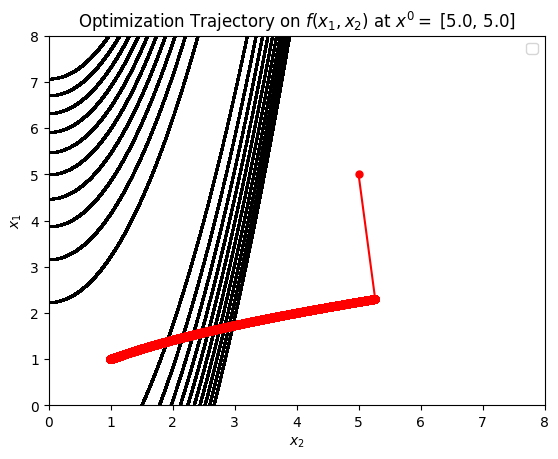

In [ ]:
# Function to solve quadratic equation
def solve_for_y(x, c_i):
    # Coefficients of the quadratic equation
    a = 100
    b = -200*x**2
    c = 100*x**4 + (x-1)**2 - c_i
    
    # Calculate discriminant
    discriminant = b**2 - 4 * a * c
    
    if discriminant < 0:
        # No real solution
        return []
    
    # Calculate the two solutions
    y1 = (-b + np.sqrt(discriminant)) / (2 * a)
    y2 = (-b - np.sqrt(discriminant)) / (2 * a)
    
    return [y1, y2]

# Contour array
c = 5000 - 500*np.linspace(0,10,11)

# Range of x values
x_values = np.linspace(-10, 10, 100000)  # Avoid division by zero by starting from a small positive value

# Calculate corresponding y values
for cntr in range(c.shape[0]):
    results = []
    c_i = c[cntr]
    for x in x_values:
        y_solutions = solve_for_y(x, c_i)
        for y in y_solutions:
            #if y > 0:  # Ensure y is positive
            results.append((x, y))
                
    
    results_array = np.zeros([len(results), 2])
    for i in range(len(results)):
        
        results_array[i,0] = results[i][0]
        results_array[i,1] = results[i][1]

    plt.scatter(results_array[:,0], results_array[:,1], s=1, c='black')

plt.plot(points_array[:,1],points_array[:,0],'-ro', markersize=5)
plt.xlim([0,8])
plt.ylim([0,8])
plt.xlabel('$x_2$')
plt.ylabel('$x_1$')
plt.legend()
plt.title(rf'Optimization Trajectory on $f(x_{1},x_{2})$ at $x^{0} =\;$[{x0[0]}, {x0[1]}]')